Importanto as bibliotecas a serem utilizadas

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

Carregando a base de dados com informações de custo do seguro saúde

In [2]:
#Importando o dataset de custo individual do seguro saúde 
datasetSeguroSaude = pd.read_csv("insurance.csv")

Conhecendo a base de dados

In [3]:
#Verificando quantidade de linhas e dimensão da base de dados
datasetSeguroSaude.shape

(1338, 7)

Temos 7 colunas, então, a dimensão é pequena, não precisamos nos preocupar com redução. 

In [4]:
#Verificando as primeiras linhas, para conhecer as características
datasetSeguroSaude.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Aqui podemos observar que:
Temos variáveis categóricas como sexo (sex), quantidade de filhos (children), fumante (smoker) e região (region); sendo que a variável fumante (smoker) é do tipo binária.
Temos valores em escalas diferentes como idade (age), índice de massa corporal (bmi) e encargos do seguro saúde (charges); sendo que a variável carges é nossa target (variável alvo).

In [5]:
#Verificando a completude dos dados
datasetSeguroSaude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No resumo acima, podemos verificar que não é necessário tratar dados nulos, pois todas as colunas possuem conteúdo em todas as linhas da base.

In [6]:
#Verificando o domínio da coluna region, para entender as variações possíveis
set(datasetSeguroSaude["region"])

{'northeast', 'northwest', 'southeast', 'southwest'}

In [7]:
#Verificando a distribuição dos dados por região
datasetSeguroSaude["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Observando os números acima, vemos que há um certo equilíbrio na distribuição dos dados por região

In [8]:
#Avaliando os dados numéricos da base
datasetSeguroSaude.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

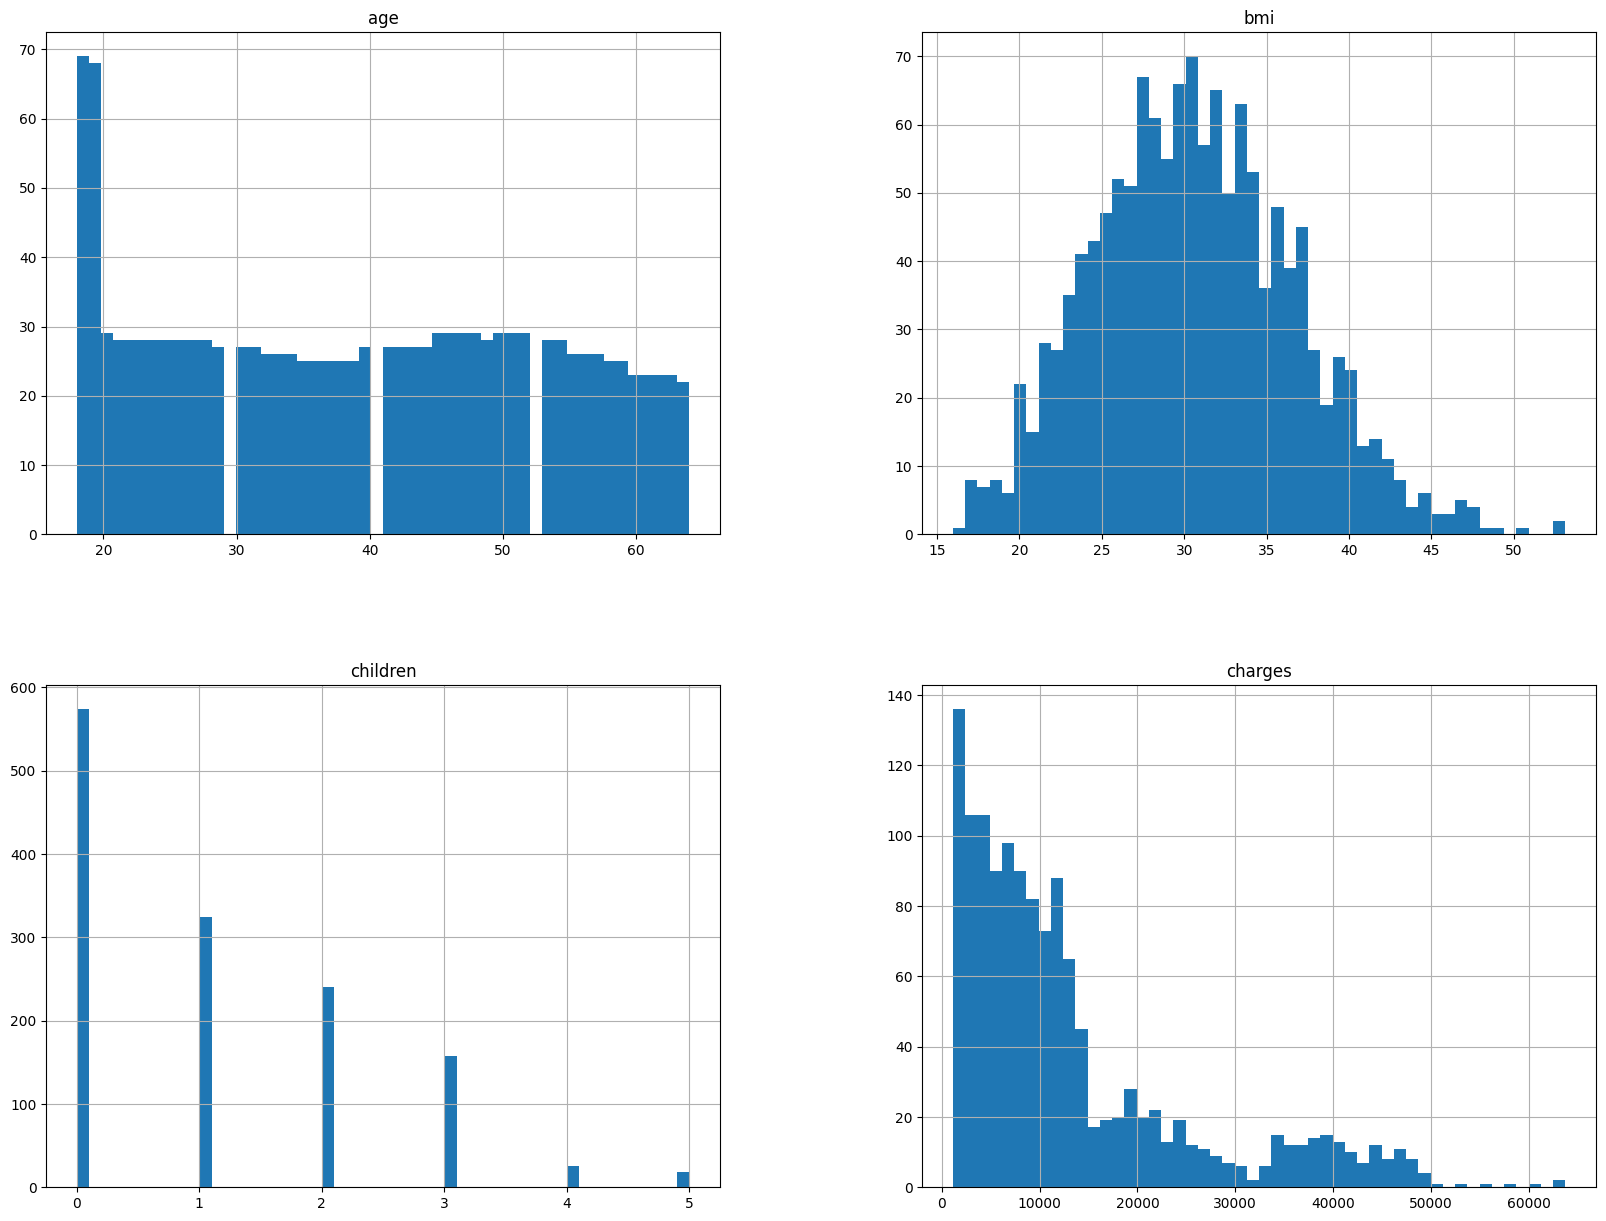

In [9]:
#Gerando histogramas para avaliar melhor a distribuição dos dados numéricos
%matplotlib inline
datasetSeguroSaude.hist(bins=50, figsize=(20,15))

Esses histogramas mostram que há uma parcela pequena de jovens, sem filhos e com peso normal, que têm um custo menor com o seguro saúde.
Também podemos ver outliers no custo e no índice de massa corporal, mostrando que temos algumas pessoas obesas, que têm um custo maior devido ao prejuízo em sua saúde. Desse modo, podemos entender que o IMC tem forte influência no custo do seguro saúde.

Analisando os dados categóricos:

In [10]:
#Verificando a distribuição dos dados por fumante/não fumante
datasetSeguroSaude["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [11]:
#Verificando o custo médio para fumante/não fumante 
datasetSeguroSaude.groupby("smoker")["charges"].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

In [12]:
#Verificando média de filhos fumante/não fumante 
datasetSeguroSaude.groupby("smoker")["children"].mean()

smoker
no     1.090226
yes    1.113139
Name: children, dtype: float64

Considerando a média de filhos para fumantes e não fumantes e a média do custo do seguro saúde, podemos inferir que a condição de fumante é bastante relevante para determinar o valor a ser pago pelo seguro, uma vez que a diferença na média de filhos é tão pequena que não deve ser relevante estatísticamente, apesar de poder indicar uma tendência. A diferença considerável entre a média de custo para fumantes e a média de custo para não fumantes deve estar associada ao prejuízo que o tabagismo traz à saúde, representando um maior risco para a empresa que administra o seguro e, portanto, o valor cobrado do segurado é maior.
Vamos criar um gráfico de correlação para entender melhor a correlação entre as demais características e o custo do seguro saúde. Porém, antes vamos tratar os dados, transformando as variáveis categóricas em variáveis numéricas.

In [13]:
#Transfomando as variáveis categóricas em variáveis numéricas utilizando o LabelEncoder
label_encoder = LabelEncoder()
datasetSeguroSaude["smoker"] = label_encoder.fit_transform(datasetSeguroSaude["smoker"])
datasetSeguroSaude["sex"] = label_encoder.fit_transform(datasetSeguroSaude["sex"])
datasetSeguroSaude["region"] = label_encoder.fit_transform(datasetSeguroSaude["region"])
datasetSeguroSaude.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'region'}>],
       [<Axes: title={'center': 'charges'}>, <Axes: >, <Axes: >]],
      dtype=object)

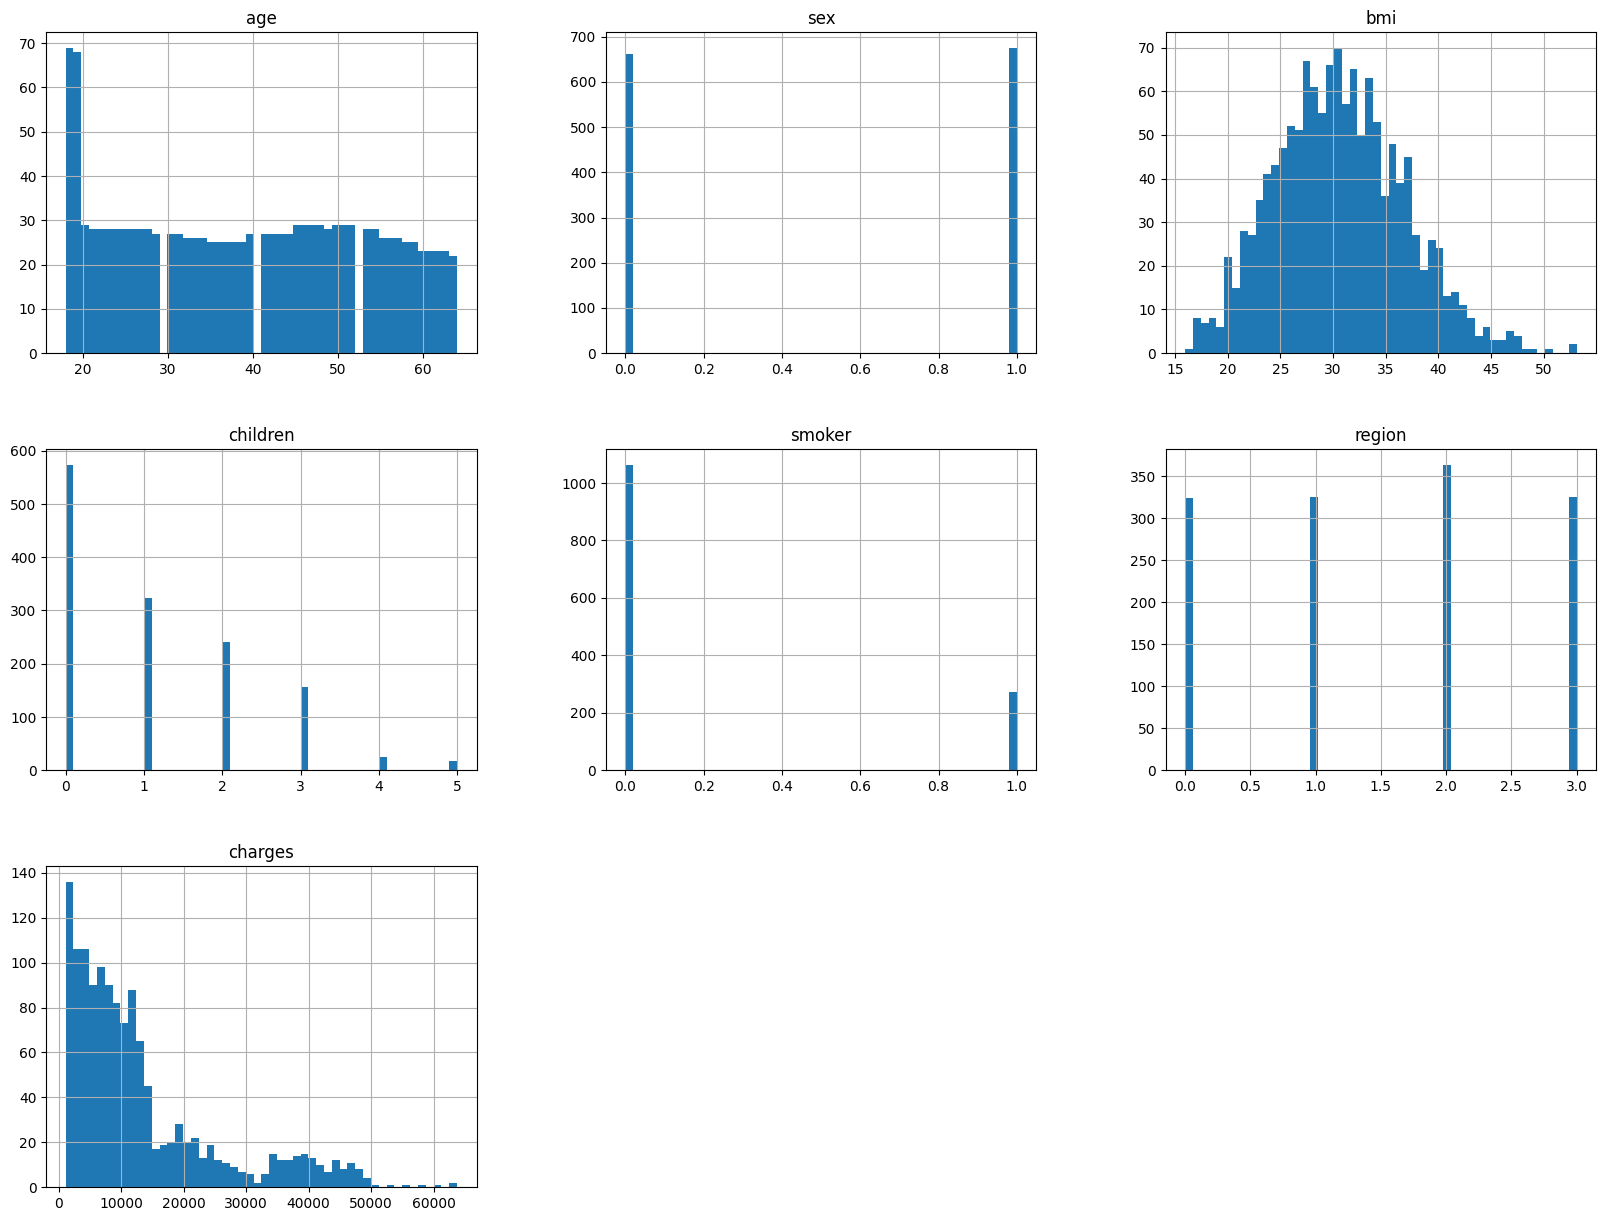

In [14]:
#Gerando histogramas novamente, agora com todos os dados numéricos
datasetSeguroSaude.hist(bins=50, figsize=(20,15))

Olhando para histograma, podemos confirmar visualmente que há um equilíbio em relação à distribuição por sexo e região. E também que a maior parte da base é não fumante.

Agora que todos os dados estão representados de forma numérica, nosso próximo passo é separar os dados em TREINO e TESTE. Utilizando 80% para TREINO e 20% para teste.
O número utlizado no random_state é arbitrário.
Vamos estratificar por IMC e identificador de fumante para garantir uma distribuição uniforme e evitar vies no conjunto de treino.

In [15]:
#Separando os dados em TREINO e TESTE

#Criando uma coluna de estrato combinando as características índice de massa corporal, idade e indicador de fumante
datasetSeguroSaude["cat1"] = pd.cut(datasetSeguroSaude["bmi"], bins=4, labels=False) # agrupando bmi em 4 categorias
datasetSeguroSaude["estrato"] = datasetSeguroSaude["cat1"].astype(str) + '_' + datasetSeguroSaude["smoker"].astype(str) 

#Separando os dados, com estratificação, para evitar enviesamento
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(datasetSeguroSaude, datasetSeguroSaude["estrato"]):
    conjunto_treino = datasetSeguroSaude.loc[train_index]
    conjunto_teste = datasetSeguroSaude.loc[test_index]

In [16]:
#Verificando treio
conjunto_treino.shape

(1070, 9)

In [17]:
#Verificando teste
conjunto_teste.shape

(268, 9)

In [18]:
#Verificando proporção do "estrato" no arquivo completo
datasetSeguroSaude["estrato"].value_counts() / len(datasetSeguroSaude)

estrato
1_0    0.447683
2_0    0.179372
0_0    0.151719
1_1    0.103886
2_1    0.053064
0_1    0.042601
3_0    0.016442
3_1    0.005232
Name: count, dtype: float64

In [19]:
#Verificando proporção do "estrato" no conjunto de treino
conjunto_treino["estrato"].value_counts() / len(conjunto_treino)

estrato
1_0    0.447664
2_0    0.179439
0_0    0.151402
1_1    0.103738
2_1    0.053271
0_1    0.042056
3_0    0.016822
3_1    0.005607
Name: count, dtype: float64

In [20]:
#Verificando proporção do "estrato" no conjunto de teste
conjunto_teste["estrato"].value_counts() / len(conjunto_teste)

estrato
1_0    0.447761
2_0    0.179104
0_0    0.152985
1_1    0.104478
2_1    0.052239
0_1    0.044776
3_0    0.014925
3_1    0.003731
Name: count, dtype: float64

In [21]:
#Separando a TARGET dos conjuntos de dados 
target_treino = conjunto_treino["charges"].copy() 
target_teste = conjunto_teste["charges"].copy() 

#Removendo as colunas não relevantes para o algoritmo
for set_ in (conjunto_treino, conjunto_teste):
    set_.drop("cat1", axis=1, inplace=True)
    set_.drop("estrato", axis=1, inplace=True)
    set_.drop("charges", axis=1, inplace=True)

#Removendo as colunas incluidas no arquivo original
datasetSeguroSaude.drop("cat1", axis=1, inplace=True)
datasetSeguroSaude.drop("estrato", axis=1, inplace=True)

In [22]:
conjunto_treino.head()

,age,sex,bmi,children,smoker,region
614,20,0,33.000,0,0,2
512,51,1,22.420,0,0,0
986,43,1,30.115,3,0,1
434,31,1,28.595,1,0,1
613,34,0,19.000,3,0,0


In [23]:
conjunto_teste.head()

,age,sex,bmi,children,smoker,region
269,49,1,25.840,1,0,0
1152,43,0,32.560,3,1,2
997,63,0,36.850,0,0,2
353,33,1,35.245,0,0,0
1095,18,0,31.350,4,0,0


In [24]:
target_treino.head()

614    1880.07000
512    9361.32680
986    8410.04685
434    4243.59005
613    6753.03800
Name: charges, dtype: float64

In [25]:
target_teste.head()

269      9282.4806
1152    40941.2854
997     13887.9685
353     12404.8791
1095     4561.1885
Name: charges, dtype: float64

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'region'}>]], dtype=object)

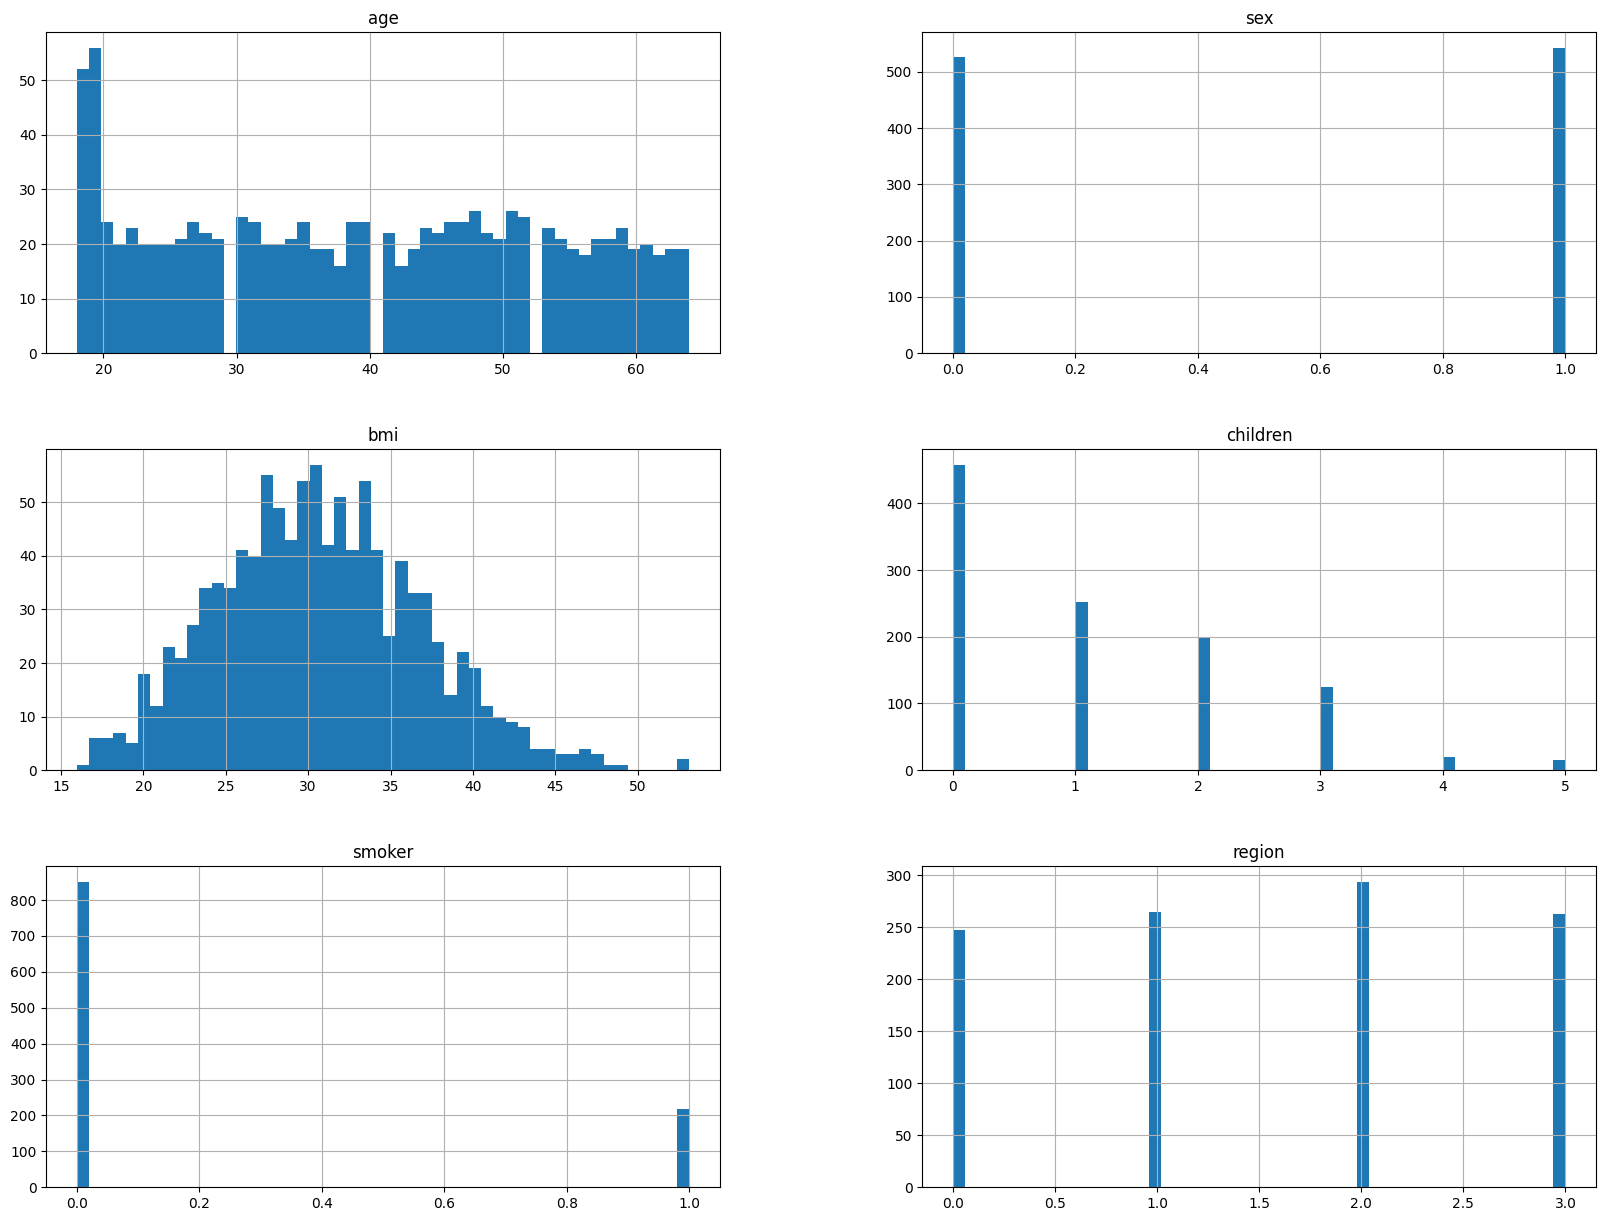

In [26]:
#Gerando histogramas conjunto treino
conjunto_treino.hist(bins=50, figsize=(20,15))

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'region'}>]], dtype=object)

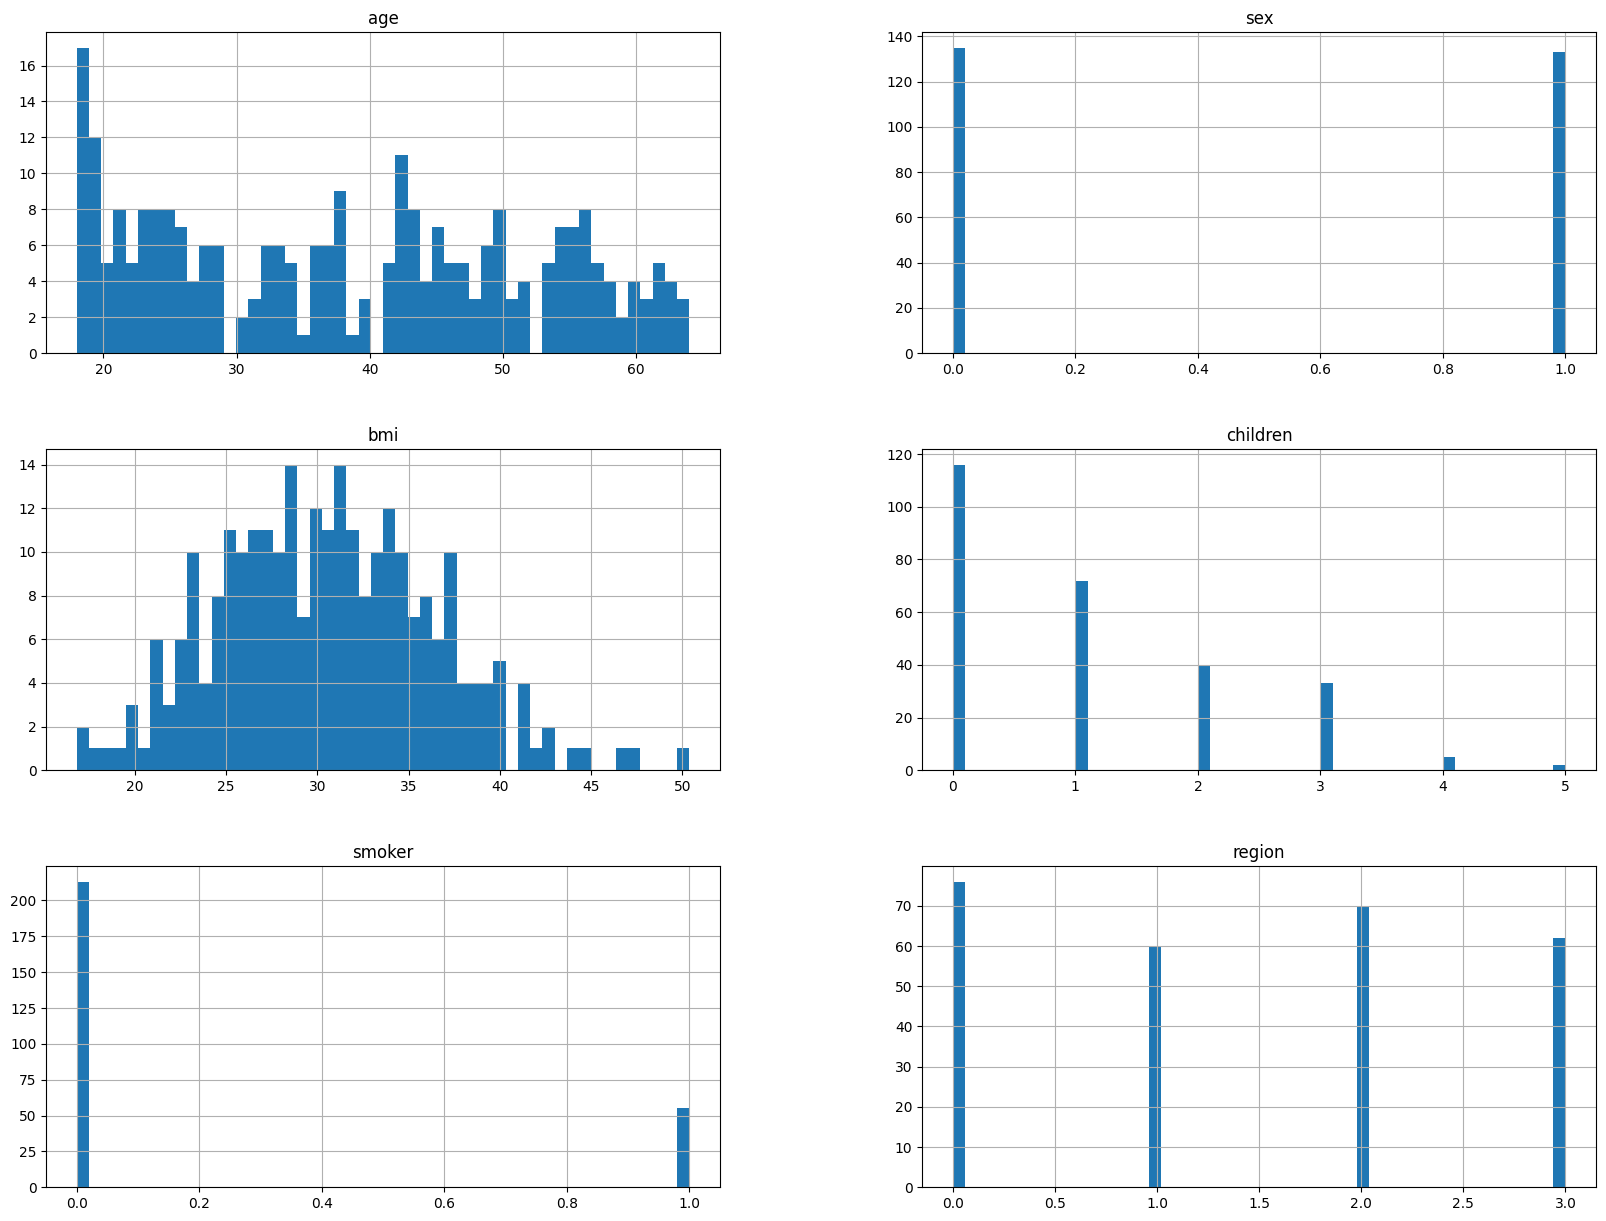

In [27]:
#Gerando histogramas conjunto teste
conjunto_teste.hist(bins=50, figsize=(20,15))

Como queremos prever valores numéricos contínuos e temos a variável TARGET (valor a ser predito), vamos primeiro testar um modelo de regressão linear (aprendizado supervisionado). Esse tipo de modelo não é sensível à escala das features e, por isso, não vamos normalizar ou padronizar.

In [28]:
#Treinando o modelo de regressão linear
regressao_linear = LinearRegression()
regressao_linear.fit(conjunto_treino, target_treino)

LinearRegression()

In [30]:
#Testando o algoritmo
predicao = regressao_linear.predict(conjunto_teste)

In [31]:
target_teste.shape

(268,)

In [32]:
predicao.shape

(268,)

In [33]:
accuracy = accuracy_score(target_teste, predicao)
print(f'Acurácia: {accuracy:.2f}')


ValueError: continuous is not supported

Devido ao problema que ainda não consegui resolver em relação à incompatilidade do resultado da predição com a TARGET de teste, não consegui realizar as métricas (MAE, MSE e RMSE) e o tempo não permitiu testar outro algoritmo, como Árvore de Decisão ou SVM.
